In [62]:
DATA_DIR = '/content/drive/MyDrive/GAN Excercise'

In [63]:
import os

print(os.listdir(DATA_DIR))

['Dataset']


In [64]:
print(os.listdir(DATA_DIR+'/Dataset')[:10])

['1007.jpg', '1006.jpg', '1.jpg', '1004.jpg', '1002.jpg', '103.jpg', '104.jpg', '108.jpg', '106.jpg', '107.jpg']


In [65]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [66]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [67]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [68]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [70]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

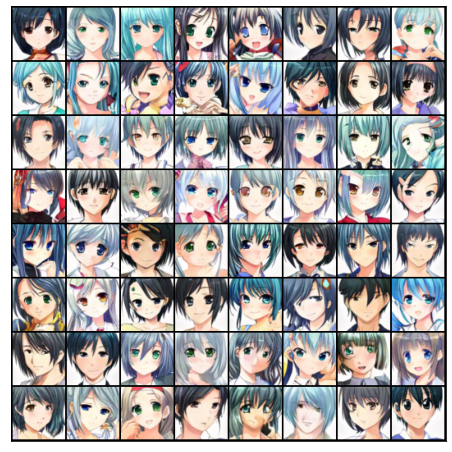

In [71]:
show_batch(train_dl)

In [72]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [73]:
device = get_default_device()
device

device(type='cpu')

In [74]:
train_dl = DeviceDataLoader(train_dl, device)

In [75]:
import torch.nn as nn

In [76]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [77]:
discriminator = to_device(discriminator, device)

In [78]:
latent_size = 128

In [79]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


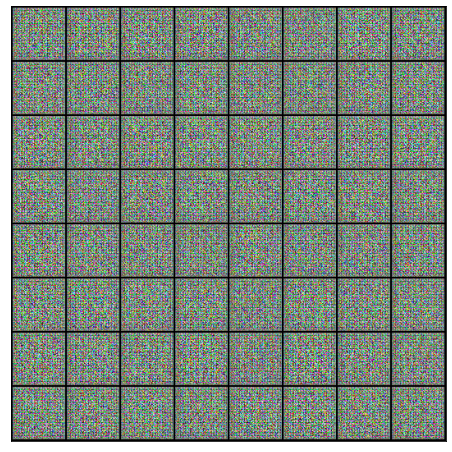

In [80]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [81]:
generator = to_device(generator, device)

In [82]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [83]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [84]:
from torchvision.utils import save_image

In [85]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [86]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [87]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


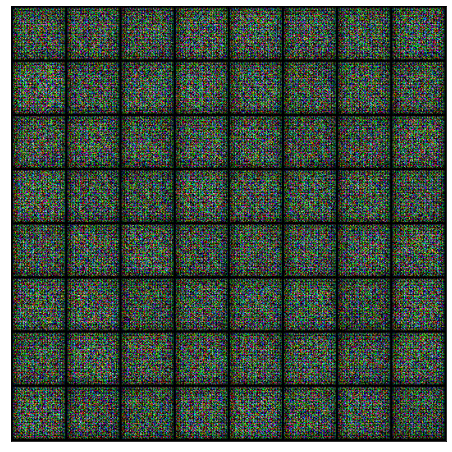

In [88]:
save_samples(0, fixed_latent)

In [89]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [90]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [102]:
lr = 0.0002
epochs = 200

In [103]:
history = fit(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 3.3307, loss_d: 0.6090, real_score: 0.6709, fake_score: 0.1118
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 3.6127, loss_d: 0.4878, real_score: 0.7218, fake_score: 0.0973
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 4.5063, loss_d: 0.5994, real_score: 0.8895, fake_score: 0.3456
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 7.7401, loss_d: 1.3585, real_score: 0.9541, fake_score: 0.6789
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 2.8539, loss_d: 0.2664, real_score: 0.9066, fake_score: 0.1437
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 3.0999, loss_d: 0.7899, real_score: 0.5999, fake_score: 0.1241
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 4.0989, loss_d: 0.7870, real_score: 0.6535, fake_score: 0.2167
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 4.7994, loss_d: 0.5156, real_score: 0.8727, fake_score: 0.2823
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 4.0634, loss_d: 0.3266, real_score: 0.8453, fake_score: 0.1107
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 7.3288, loss_d: 1.0280, real_score: 0.8100, fake_score: 0.5196
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 6.3941, loss_d: 0.8989, real_score: 0.8644, fake_score: 0.4708
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 3.5389, loss_d: 0.8675, real_score: 0.5087, fake_score: 0.0267
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 6.6152, loss_d: 0.6971, real_score: 0.8507, fake_score: 0.3748
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 6.2310, loss_d: 1.0814, real_score: 0.9031, fake_score: 0.5717
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 4.2466, loss_d: 1.0225, real_score: 0.4582, fake_score: 0.0192
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 5.1864, loss_d: 0.5744, real_score: 0.8520, fake_score: 0.2906
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 3.0088, loss_d: 0.8528, real_score: 0.4949, fake_score: 0.0151
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 3.7812, loss_d: 0.5090, real_score: 0.7214, fake_score: 0.0958
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 3.8138, loss_d: 0.6222, real_score: 0.8299, fake_score: 0.3133
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.0010, loss_d: 0.6246, real_score: 0.6946, fake_score: 0.1482
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.4072, loss_d: 0.5304, real_score: 0.8991, fake_score: 0.3228
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 2.5776, loss_d: 0.4566, real_score: 0.7471, fake_score: 0.1091
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 6.1427, loss_d: 0.7771, real_score: 0.8610, fake_score: 0.4214
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 4.9873, loss_d: 0.8227, real_score: 0.5171, fake_score: 0.0129
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 4.2747, loss_d: 0.4605, real_score: 0.7506, fake_score: 0.1115
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 6.0474, loss_d: 0.7270, real_score: 0.9661, fake_score: 0.4655
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.9011, loss_d: 0.3871, real_score: 0.9053, fake_score: 0.2276
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.5982, loss_d: 0.7807, real_score: 0.5459, fake_score: 0.0183
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 3.1560, loss_d: 0.7106, real_score: 0.5617, fake_score: 0.0176
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 3.7095, loss_d: 0.4898, real_score: 0.7457, fake_score: 0.1268
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.3200, loss_d: 0.4921, real_score: 0.7496, fake_score: 0.1475
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 2.5859, loss_d: 0.3630, real_score: 0.7975, fake_score: 0.0942
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 3.0696, loss_d: 0.5112, real_score: 0.7415, fake_score: 0.1384
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 4.0786, loss_d: 0.5794, real_score: 0.8873, fake_score: 0.3375
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 5.7027, loss_d: 0.7055, real_score: 0.9585, fake_score: 0.4526
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 5.5649, loss_d: 0.3268, real_score: 0.9116, fake_score: 0.1934
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 8.7409, loss_d: 1.1067, real_score: 0.9457, fake_score: 0.6256
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 2.9249, loss_d: 0.3262, real_score: 0.8551, fake_score: 0.1337
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 3.2479, loss_d: 0.3755, real_score: 0.7955, fake_score: 0.1138
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 4.7081, loss_d: 0.5729, real_score: 0.6399, fake_score: 0.0175
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.8914, loss_d: 0.3692, real_score: 0.8430, fake_score: 0.1536
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 6.9327, loss_d: 0.6831, real_score: 0.8789, fake_score: 0.3989
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 7.1788, loss_d: 0.6790, real_score: 0.9556, fake_score: 0.4445
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 5.7688, loss_d: 1.5400, real_score: 0.2944, fake_score: 0.0019
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 3.6329, loss_d: 0.5487, real_score: 0.6824, fake_score: 0.0813
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 8.6592, loss_d: 1.2673, real_score: 0.8934, fake_score: 0.6406
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 6.8461, loss_d: 0.7925, real_score: 0.9767, fake_score: 0.4916
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 4.9671, loss_d: 0.6339, real_score: 0.8263, fake_score: 0.3115
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 5.8685, loss_d: 0.4366, real_score: 0.8991, fake_score: 0.2599
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 3.4099, loss_d: 0.5157, real_score: 0.7056, fake_score: 0.1049
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.6492, loss_d: 0.3909, real_score: 0.9620, fake_score: 0.2774
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 6.7669, loss_d: 0.5856, real_score: 0.8524, fake_score: 0.3121
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 4.9563, loss_d: 0.5538, real_score: 0.9446, fake_score: 0.3642
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.3372, loss_d: 0.4190, real_score: 0.7747, fake_score: 0.1167
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 4.0331, loss_d: 0.3815, real_score: 0.9014, fake_score: 0.2189
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 4.6843, loss_d: 0.4585, real_score: 0.8192, fake_score: 0.1974
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 5.5814, loss_d: 0.4254, real_score: 0.7069, fake_score: 0.0134
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.0454, loss_d: 1.0365, real_score: 0.4483, fake_score: 0.0267
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 3.1856, loss_d: 1.1698, real_score: 0.3808, fake_score: 0.0093
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 4.4393, loss_d: 0.4823, real_score: 0.9304, fake_score: 0.3082
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 2.5076, loss_d: 0.5663, real_score: 0.6435, fake_score: 0.0438
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 3.9209, loss_d: 0.4291, real_score: 0.7150, fake_score: 0.0311
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 4.9035, loss_d: 0.5626, real_score: 0.8987, fake_score: 0.3366
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 5.6246, loss_d: 0.5957, real_score: 0.8149, fake_score: 0.2869
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 5.1781, loss_d: 0.5349, real_score: 0.8485, fake_score: 0.2619
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 4.5127, loss_d: 0.8376, real_score: 0.5175, fake_score: 0.0063
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 3.5354, loss_d: 0.4349, real_score: 0.7862, fake_score: 0.1422
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 5.0383, loss_d: 0.2632, real_score: 0.9265, fake_score: 0.1568
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 8.8240, loss_d: 0.9736, real_score: 0.9624, fake_score: 0.5633
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 3.6180, loss_d: 0.4269, real_score: 0.7465, fake_score: 0.0819
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 6.5535, loss_d: 0.8125, real_score: 0.9858, fake_score: 0.5018
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 7.1369, loss_d: 0.7786, real_score: 0.8996, fake_score: 0.4490
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.5702, loss_d: 0.4003, real_score: 0.8530, fake_score: 0.1913
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 4.2099, loss_d: 0.3204, real_score: 0.8579, fake_score: 0.1295
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 9.8982, loss_d: 1.1663, real_score: 0.9892, fake_score: 0.6262
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 3.5972, loss_d: 0.3588, real_score: 0.9125, fake_score: 0.2117
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 3.8506, loss_d: 0.3119, real_score: 0.8409, fake_score: 0.1148
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 6.6315, loss_d: 0.5141, real_score: 0.9158, fake_score: 0.3197
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 5.4577, loss_d: 0.1937, real_score: 0.9361, fake_score: 0.1080
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 5.3901, loss_d: 0.4257, real_score: 0.8645, fake_score: 0.2146
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 3.1785, loss_d: 0.5684, real_score: 0.6386, fake_score: 0.0250
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.5761, loss_d: 0.5257, real_score: 0.6750, fake_score: 0.0410
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 6.4691, loss_d: 0.5200, real_score: 0.9179, fake_score: 0.3258
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 2.6800, loss_d: 0.4118, real_score: 0.7431, fake_score: 0.0724
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 2.4104, loss_d: 0.5797, real_score: 0.6449, fake_score: 0.0426
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.2796, loss_d: 0.3153, real_score: 0.7881, fake_score: 0.0385
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.2991, loss_d: 0.4146, real_score: 0.7289, fake_score: 0.0211
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 6.1808, loss_d: 0.4660, real_score: 0.8795, fake_score: 0.2594
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 8.2765, loss_d: 0.6844, real_score: 0.9323, fake_score: 0.4065
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 4.0122, loss_d: 0.3161, real_score: 0.7852, fake_score: 0.0366
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 7.1726, loss_d: 0.3530, real_score: 0.7381, fake_score: 0.0044
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 5.3409, loss_d: 0.3163, real_score: 0.7580, fake_score: 0.0090
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 3.7163, loss_d: 2.1873, real_score: 0.1756, fake_score: 0.0007
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.7352, loss_d: 0.3093, real_score: 0.9458, fake_score: 0.2070
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 9.2757, loss_d: 0.9670, real_score: 0.9828, fake_score: 0.5467
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 4.5531, loss_d: 0.5726, real_score: 0.9455, fake_score: 0.3522
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 3.3527, loss_d: 0.3663, real_score: 0.7635, fake_score: 0.0497
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 6.3643, loss_d: 0.6497, real_score: 0.9352, fake_score: 0.4026
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.2369, loss_d: 0.9352, real_score: 0.4635, fake_score: 0.0032
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 4.0636, loss_d: 0.3770, real_score: 0.7349, fake_score: 0.0272
Saving generated-images-0100.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 3.9359, loss_d: 0.3790, real_score: 0.9878, fake_score: 0.2694
Saving generated-images-0101.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.5177, loss_d: 0.3342, real_score: 0.9526, fake_score: 0.2299
Saving generated-images-0102.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.6418, loss_d: 0.5947, real_score: 0.5996, fake_score: 0.0058
Saving generated-images-0103.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 2.9931, loss_d: 0.8029, real_score: 0.5193, fake_score: 0.0134
Saving generated-images-0104.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.1824, loss_d: 0.2583, real_score: 0.9254, fake_score: 0.1516
Saving generated-images-0105.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.2709, loss_d: 0.2594, real_score: 0.9197, fake_score: 0.1423
Saving generated-images-0106.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 6.4918, loss_d: 0.4801, real_score: 0.9677, fake_score: 0.3270
Saving generated-images-0107.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.3880, loss_d: 0.1984, real_score: 0.9045, fake_score: 0.0841
Saving generated-images-0108.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 8.6696, loss_d: 0.7460, real_score: 0.9833, fake_score: 0.4730
Saving generated-images-0109.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 7.9300, loss_d: 1.0014, real_score: 0.9936, fake_score: 0.5740
Saving generated-images-0110.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 6.7136, loss_d: 0.6952, real_score: 0.9157, fake_score: 0.4019
Saving generated-images-0111.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 6.7283, loss_d: 0.4423, real_score: 0.9365, fake_score: 0.2854
Saving generated-images-0112.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 3.2398, loss_d: 1.5170, real_score: 0.2993, fake_score: 0.0014
Saving generated-images-0113.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.0516, loss_d: 1.1889, real_score: 0.3881, fake_score: 0.0035
Saving generated-images-0114.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 6.2035, loss_d: 0.3089, real_score: 0.9485, fake_score: 0.2100
Saving generated-images-0115.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 3.6329, loss_d: 0.1027, real_score: 0.9541, fake_score: 0.0511
Saving generated-images-0116.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 4.3837, loss_d: 0.2797, real_score: 0.9900, fake_score: 0.2229
Saving generated-images-0117.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 3.6247, loss_d: 0.2184, real_score: 0.8799, fake_score: 0.0699
Saving generated-images-0118.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 7.7505, loss_d: 0.5744, real_score: 0.9413, fake_score: 0.3804
Saving generated-images-0119.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 7.7091, loss_d: 0.4862, real_score: 0.9579, fake_score: 0.3287
Saving generated-images-0120.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 3.2846, loss_d: 0.3344, real_score: 0.7740, fake_score: 0.0356
Saving generated-images-0121.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 3.3694, loss_d: 0.2108, real_score: 0.9540, fake_score: 0.1373
Saving generated-images-0122.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 8.2917, loss_d: 0.7727, real_score: 0.9952, fake_score: 0.4788
Saving generated-images-0123.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 7.2536, loss_d: 0.5155, real_score: 0.9741, fake_score: 0.3511
Saving generated-images-0124.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 6.9013, loss_d: 0.5080, real_score: 0.9472, fake_score: 0.3263
Saving generated-images-0125.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 2.2545, loss_d: 0.8729, real_score: 0.4840, fake_score: 0.0095
Saving generated-images-0126.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 4.5833, loss_d: 0.2294, real_score: 0.8782, fake_score: 0.0854
Saving generated-images-0127.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 2.7940, loss_d: 0.1456, real_score: 0.9820, fake_score: 0.1140
Saving generated-images-0128.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.4853, loss_d: 0.2795, real_score: 0.8915, fake_score: 0.1359
Saving generated-images-0129.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 6.6893, loss_d: 0.3721, real_score: 0.9585, fake_score: 0.2597
Saving generated-images-0130.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 9.0734, loss_d: 0.6711, real_score: 0.9406, fake_score: 0.4176
Saving generated-images-0131.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 3.6997, loss_d: 0.2802, real_score: 0.8536, fake_score: 0.0988
Saving generated-images-0132.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 6.7657, loss_d: 0.3868, real_score: 0.9456, fake_score: 0.2567
Saving generated-images-0133.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.0473, loss_d: 0.5566, real_score: 0.6479, fake_score: 0.0077
Saving generated-images-0134.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 6.4088, loss_d: 0.2931, real_score: 0.9401, fake_score: 0.1887
Saving generated-images-0135.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 5.7608, loss_d: 0.2637, real_score: 0.9449, fake_score: 0.1763
Saving generated-images-0136.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.5140, loss_d: 0.1587, real_score: 0.9138, fake_score: 0.0580
Saving generated-images-0137.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 8.6949, loss_d: 2.0580, real_score: 0.9897, fake_score: 0.8094
Saving generated-images-0138.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 5.2315, loss_d: 0.6674, real_score: 0.8357, fake_score: 0.3292
Saving generated-images-0139.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 4.0777, loss_d: 0.7368, real_score: 0.5320, fake_score: 0.0068
Saving generated-images-0140.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 3.9762, loss_d: 0.2919, real_score: 0.8148, fake_score: 0.0602
Saving generated-images-0141.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.2490, loss_d: 0.2874, real_score: 0.8754, fake_score: 0.1270
Saving generated-images-0142.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 7.2100, loss_d: 0.4794, real_score: 0.9852, fake_score: 0.3180
Saving generated-images-0143.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 7.1894, loss_d: 0.6183, real_score: 0.9807, fake_score: 0.4103
Saving generated-images-0144.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 3.8088, loss_d: 0.2422, real_score: 0.9315, fake_score: 0.1473
Saving generated-images-0145.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.1867, loss_d: 0.2120, real_score: 0.9092, fake_score: 0.0996
Saving generated-images-0146.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 3.9619, loss_d: 0.2550, real_score: 0.8630, fake_score: 0.0834
Saving generated-images-0147.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 4.7773, loss_d: 0.2053, real_score: 0.9268, fake_score: 0.1091
Saving generated-images-0148.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.8669, loss_d: 0.1862, real_score: 0.8788, fake_score: 0.0436
Saving generated-images-0149.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 3.6738, loss_d: 0.1026, real_score: 0.9647, fake_score: 0.0594
Saving generated-images-0150.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 3.4917, loss_d: 0.3657, real_score: 0.7507, fake_score: 0.0243
Saving generated-images-0151.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.5588, loss_d: 0.2923, real_score: 0.8794, fake_score: 0.1361
Saving generated-images-0152.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 7.4300, loss_d: 0.2363, real_score: 0.8149, fake_score: 0.0035
Saving generated-images-0153.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 7.7902, loss_d: 0.5580, real_score: 0.6307, fake_score: 0.0007
Saving generated-images-0154.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.9521, loss_d: 0.1516, real_score: 0.9057, fake_score: 0.0420
Saving generated-images-0155.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 3.4378, loss_d: 0.1295, real_score: 0.9806, fake_score: 0.0989
Saving generated-images-0156.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.7689, loss_d: 0.2463, real_score: 0.8932, fake_score: 0.1112
Saving generated-images-0157.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 3.4313, loss_d: 2.2635, real_score: 0.1545, fake_score: 0.0002
Saving generated-images-0158.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 7.0494, loss_d: 0.4427, real_score: 0.9856, fake_score: 0.3099
Saving generated-images-0159.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.7433, loss_d: 0.0607, real_score: 0.9696, fake_score: 0.0275
Saving generated-images-0160.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 4.6996, loss_d: 0.2981, real_score: 0.7810, fake_score: 0.0119
Saving generated-images-0161.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 5.8212, loss_d: 0.2960, real_score: 0.9304, fake_score: 0.1849
Saving generated-images-0162.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 5.9378, loss_d: 0.0965, real_score: 0.9708, fake_score: 0.0621
Saving generated-images-0163.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.6235, loss_d: 0.3036, real_score: 0.7758, fake_score: 0.0159
Saving generated-images-0164.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 4.5430, loss_d: 0.0892, real_score: 0.9285, fake_score: 0.0095
Saving generated-images-0165.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 7.2050, loss_d: 0.2993, real_score: 0.9457, fake_score: 0.2016
Saving generated-images-0166.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 4.9313, loss_d: 0.2202, real_score: 0.9101, fake_score: 0.1065
Saving generated-images-0167.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 2.7619, loss_d: 0.3565, real_score: 0.7387, fake_score: 0.0109
Saving generated-images-0168.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 2.7026, loss_d: 0.3315, real_score: 0.7733, fake_score: 0.0317
Saving generated-images-0169.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 5.8256, loss_d: 0.6064, real_score: 0.8701, fake_score: 0.3293
Saving generated-images-0170.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 3.5542, loss_d: 1.7578, real_score: 0.2590, fake_score: 0.0021
Saving generated-images-0171.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 4.5365, loss_d: 0.2487, real_score: 0.8437, fake_score: 0.0513
Saving generated-images-0172.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 5.6132, loss_d: 0.2429, real_score: 0.9477, fake_score: 0.1605
Saving generated-images-0173.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 6.3546, loss_d: 0.2658, real_score: 0.9572, fake_score: 0.1851
Saving generated-images-0174.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 5.2557, loss_d: 0.4965, real_score: 0.6646, fake_score: 0.0023
Saving generated-images-0175.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 5.6729, loss_d: 0.2009, real_score: 0.9671, fake_score: 0.1453
Saving generated-images-0176.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.4200, loss_d: 0.1991, real_score: 0.9037, fake_score: 0.0832
Saving generated-images-0177.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 6.3633, loss_d: 0.6895, real_score: 0.5713, fake_score: 0.0005
Saving generated-images-0178.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 8.2155, loss_d: 0.4496, real_score: 0.9747, fake_score: 0.3039
Saving generated-images-0179.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 5.7926, loss_d: 0.2452, real_score: 0.9666, fake_score: 0.1798
Saving generated-images-0180.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 3.3704, loss_d: 0.2693, real_score: 0.8003, fake_score: 0.0222
Saving generated-images-0181.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 4.9995, loss_d: 0.1563, real_score: 0.9471, fake_score: 0.0903
Saving generated-images-0182.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 5.0595, loss_d: 0.1181, real_score: 0.9154, fake_score: 0.0226
Saving generated-images-0183.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 7.3120, loss_d: 0.3372, real_score: 0.9878, fake_score: 0.2521
Saving generated-images-0184.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 4.5213, loss_d: 0.1554, real_score: 0.9385, fake_score: 0.0819
Saving generated-images-0185.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 7.9648, loss_d: 0.2381, real_score: 0.9941, fake_score: 0.1886
Saving generated-images-0186.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 5.2951, loss_d: 0.1990, real_score: 0.9734, fake_score: 0.1489
Saving generated-images-0187.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 9.8734, loss_d: 2.7159, real_score: 0.1219, fake_score: 0.0000
Saving generated-images-0188.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 2.8437, loss_d: 4.0541, real_score: 0.0446, fake_score: 0.0003
Saving generated-images-0189.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 6.4782, loss_d: 1.5967, real_score: 0.2832, fake_score: 0.0005
Saving generated-images-0190.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 7.8270, loss_d: 0.7834, real_score: 0.9896, fake_score: 0.4922
Saving generated-images-0191.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 5.6012, loss_d: 0.4396, real_score: 0.9542, fake_score: 0.2946
Saving generated-images-0192.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 5.0720, loss_d: 0.2789, real_score: 0.9337, fake_score: 0.1785
Saving generated-images-0193.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 6.2115, loss_d: 0.3150, real_score: 0.9370, fake_score: 0.2060
Saving generated-images-0194.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 7.7031, loss_d: 0.4324, real_score: 0.9903, fake_score: 0.3121
Saving generated-images-0195.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 5.3564, loss_d: 0.2390, real_score: 0.9400, fake_score: 0.1532
Saving generated-images-0196.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 5.7283, loss_d: 0.1265, real_score: 0.9684, fake_score: 0.0856
Saving generated-images-0197.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 4.3892, loss_d: 0.1558, real_score: 0.9501, fake_score: 0.0930
Saving generated-images-0198.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 5.4397, loss_d: 0.2389, real_score: 0.9553, fake_score: 0.1620
Saving generated-images-0199.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 11.0978, loss_d: 0.9766, real_score: 0.9990, fake_score: 0.5189
Saving generated-images-0200.png


In [104]:
losses_g, losses_d, real_scores, fake_scores = history

In [105]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [106]:
from IPython.display import Image

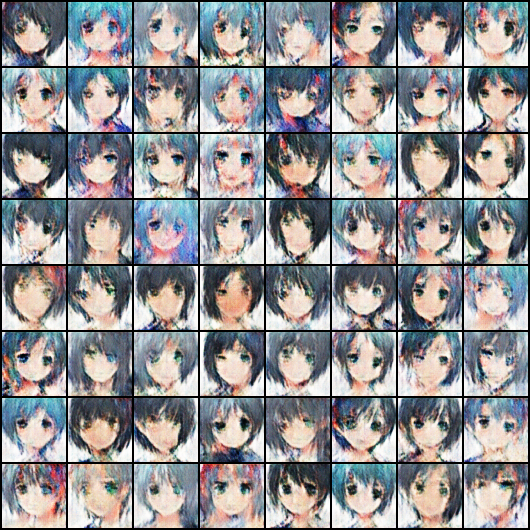

In [107]:
Image('./generated/generated-images-0200.png')

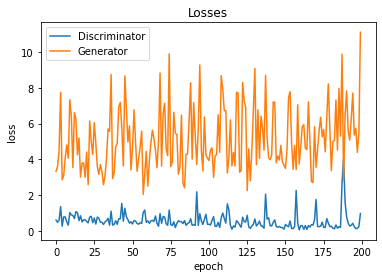

In [108]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

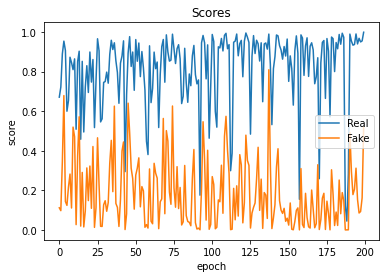

In [109]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');